In [17]:
import numpy as np
import pickle

from matplotlib import pyplot as plt
from scipy.special import expit

from PIL import Image, ImageDraw, ImageOps

from tabulate import tabulate

import tkinter as tk


np.seterr(all='raise')


{'divide': 'raise', 'over': 'raise', 'under': 'raise', 'invalid': 'raise'}

In [18]:
def takeinputs():

    with open('valeursentraine', 'rb') as f:
        valeurs = np.array(pickle.load(f))

    with open('pixelsentraine', 'rb') as f:
        pixels = np.array(pickle.load(f)).T

    with open('testval', 'rb') as f:
        qcmval = pickle.load(f)

    with open('testpix', 'rb') as f:
        qcmpix = np.array(pickle.load(f)).T

    perm = np.random.permutation(pixels.shape[1])

    pixmelange = pixels[:, perm]
    valmelange = valeurs[perm]

    return valmelange, pixmelange, qcmval, qcmpix

val, pix, qcmval, qcmpix = takeinputs()


In [53]:
class Draw:
    def __init__(self):
        self.root = tk.Tk()
        self.root.title("Paint")

        self.canvas = tk.Canvas(self.root, width=280, height=280, bg="black")
        self.canvas.pack()

        self.dessine = False

        self.posx, self.posy = None,None

        self.butons = []

        self.image = Image.new("L", (280, 280), 255)
        self.drawing = ImageDraw.Draw(self.image)

        self.pixels = None

        self.creerboutons()

        self.root.mainloop()

    def creerboutons(self):
        imprimer = tk.Button(self.root, text="Print", command=self.imprime)
        imprimer.pack(side=tk.LEFT)

        fermer = tk.Button(self.root, text="Fermer", command=self.root.destroy)
        fermer.pack(side=tk.LEFT)

        self.butons.append(imprimer)
        self.butons.append(fermer)


        self.canvas.bind("<Button-1>", self.commence)
        self.canvas.bind("<ButtonRelease-1>", self.arret)
        self.canvas.bind("<B1-Motion>", self.draw)

    def commence(self, event):
        self.dessine = True
        self.posx, self.posy = event.x, event.y

    def arret(self, event):
        self.dessine = False

    def draw(self, event):
        if self.dessine:
            x, y = event.x, event.y

            self.canvas.create_line((self.posx, self.posy, x, y), fill="white", width=10)

            self.drawing.line([self.posx, self.posy, x, y], fill=0, width=8)

            self.posx, self.posy = x, y



    def imprime(self):
        im = self.image.resize((28, 28), Image.Resampling.LANCZOS)

        im = ImageOps.invert(im)

        # im.show()

        self.pixels = np.array(im.getdata()).reshape(-1,1)


        self.root.destroy()


class NN:
    def __init__(self, pix, vales, infolay, errorfunc, qcmpix, qcmval, *, coefcv=0.1, iterations=1, batch=1, apprentissagedynamique=False):
        self.iter = iterations  # nombre iteration entrainement
        self.nblay = len(infolay)-1 # nombre de layers
        self.lenbatch = batch

        # INITIALISATION VARIABLES
        self.cvcoef = coefcv

        # INPUTS POUR ENTRAINEMENT
        self.pix = self.processdata(pix, qcm=False) #pix de train
        self.vales = vales #val de train

        self.qcmpix = self.processdata(qcmpix, qcm=True)
        self.qcmval = qcmval

        self.parameters = self.params(infolay) #creer les parametres dans un dico/ infolay doit avoir tout au debut la longueur de l'input
        self.dimweights = [(infolay[l][0], infolay[l-1][0]) for l in range(1, len(infolay))]

        self.errorfunc = self.geterrorfunc(errorfunc)[0] #choisir la fonction d'erreur
        self.differrorfunc = self.geterrorfunc(errorfunc)[1]

        self.aprentissagedynamique = apprentissagedynamique



    def printbasesimple(self, base):
        print(tabulate(base.reshape((28, 28))))

    def printcouleur(self, base, titre):
        df2 = base.reshape((28,28))
        plt.imshow(df2, cmap='Greys', interpolation='nearest')
        plt.colorbar(label='Value')
        plt.title(titre)
        plt.show()


    def processdata(self, pix, qcm): #mettre les donnees sous la bonne forme
        if qcm:
            datamod = pix
        else:
            datamod = pix/255
            # datamod = dat[:, np.random.permutation(dat.shape[1])]

        return datamod

    def params(self, lst): #lst liste avec un tuple avec (nbneurons, fctactivation)
        param = {}

        for l in range(1, len(lst)):
            param["w" + str(l-1)] = np.random.randn(lst[l][0], lst[l-1][0]) * np.sqrt(1 / lst[l-1][0])
            # #np.random.uniform(-1, 1, (lst[l][0], lst[l-1][0])) #nbneurons * nbinput
            param["b" + str(l-1)] = np.random.rand(lst[l][0], 1) - 0.5 #np.zeros((lst[l][0], 1))
            param["fct" + str(l-1)] = self.getfct(lst[l][1])[0]
            param["diff" + str(l-1)] = self.getfct(lst[l][1])[1]
        return param

    def geterrorfunc(self, errorfunc): #exp est un onehotvect
        if errorfunc == "eqm":
            def eqm(obs, exp, nbinput):
                return (np.sum((obs - exp) ** 2, axis=0))/ (2 * nbinput)
            def eqmdif(obs, expected, nbinput):
                return  (obs - expected)/nbinput
            return [eqm, eqmdif]

        elif errorfunc == "CEL":
            def CEL(obs, exp, nbinput):
                return -np.sum(exp * np.log(np.clip(obs, 1e-9, 1 - 1e-9)), axis=0) / nbinput
            def CELdif(obs, exp, nbinput):
                return (obs - exp) / nbinput
            return [CEL, CELdif]

        else:
            raise ValueError("errorfunc must be specified")

    def getfct(self, acti):
        if acti == 'sigmoid':
            def sigmoid(x):
                return expit(x)
            def sigmoiddif(x):
                return (expit(x)) * (1 - expit(x))
            return [sigmoid, sigmoiddif]

        elif acti == 'relu':
            def relu(x):
                return np.maximum(x, 0)
            def reludif(x):
                return np.where(x >= 0, 1, 0)
            return [relu, reludif]

        elif acti == 'tanh':
            def tan(x):
                return np.tanh(x)
            def tandiff(x):
                return 1 - np.square(np.tanh(x))
            return [tan, tandiff]

        elif acti == 'softmaxaprox':
            def softmaxaprox(x):
                x = x - np.max(x, axis=0, keepdims=True)
                return np.exp(x) / np.sum(np.exp(x), axis=0, keepdims=True)

            def softmaxaproxdif(output):
                return output * (1 - output)

            return [softmaxaprox, softmaxaproxdif]

        elif acti == 'softmax':
            def softmax(x):
                x = x - np.max(x, axis=0, keepdims=True)
                return np.exp(x) / np.sum(np.exp(x), axis=0, keepdims=True)

            def softmaxdif(output):
                n = output.shape[0]
                jacobian = np.zeros((n, n))

                for i in range(n):
                    for j in range(n):
                        if i == j:
                            jacobian[i, j] = output[i] * (1 - output[i])
                        else:
                            jacobian[i, j] = -output[i] * output[j]

                return jacobian

            return [softmax, softmaxdif]

        elif acti == "leakyrelu":
            def leakyrelu(x):
                return np.maximum(self.cvcoef * x, 0)

            def leakyreludif(x):
                return np.where(x > 0, self.cvcoef, 0)

            return [leakyrelu, leakyreludif]

        else:
            raise "You forgot to specify the activation function"

    def forwardprop(self, input): #forward all the layers until output
        outlast = input
        activations = [input] #garder pour la backprop les variables
        zs = []
        for l in range(0, self.nblay):
            w = self.parameters["w" + str(l)]
            b = self.parameters["b" + str(l)]
            z = np.dot(w, outlast) + b
            if np.isinf(z).any():
                print("inf", np.isinf(z))
                print("________________________________________________________________")
                print("w", w)
                print("________________________________________________________________")
                print("out", outlast)
                print("________________________________________________________________")
                print("profuit", np.dot(w, outlast))
                print("_______________________________________________________________")
                print("b", b)
                print("________________________________________________________________")
                print("z", z)
                print("________________________________________________________________")
                raise Exception("something went wrong")
            a = self.parameters["fct" + str(l)](z)

            zs.append(z)
            activations.append(a)
            outlast = a

        return outlast, zs, activations #out last c'est la prediction et vieux c'est pour backprop

    def backprop(self, expected, zs, activations, nbinp):
        C = self.errorfunc(activations[-1], expected, nbinp)

        dw = [np.zeros(self.dimweights[i]) for i in range(self.nblay)]
        db = [np.zeros((self.dimweights[i][0], 1)) for i in range(self.nblay)]

        delta = self.differrorfunc(activations[-1], expected, nbinp)

        dw[-1] += np.dot(delta, activations[-2].T)
        db[-1] += np.sum(delta, axis=1, keepdims=True)

        for l in range(self.nblay - 2, -1, -1):
            w = self.parameters["w" + str(l + 1)]
            dif = self.parameters["diff" + str(l)](zs[l])

            delta = np.dot(w.T, delta) * dif

            dwl = np.dot(delta, activations[l].T)
            dbl = np.sum(delta, axis=1, keepdims=True)

            dw[l] += dwl
            db[l] += dbl

        return dw, db, C

    def actualiseweights(self, dw, db, nbinput):
        for l in range(0,self.nblay):
            self.parameters["w" + str(l)] -= self.cvcoef * dw[l] * (1/nbinput)
            self.parameters["b" + str(l)] -= self.cvcoef * db[l] * (1/nbinput)
        return

    def trainsimple(self):
        # Ctot = []
        for _ in range(self.iter):
            for p in range(self.pix.shape[1]):
                forw = self.forwardprop(self.pix[:,p].reshape(-1,1))

                dw, db, loss = self.backprop(self.vecteur(self.vales[p]), forw[1], forw[2], 1)

                # Ctot.append(loss)

                self.actualiseweights(dw, db, 1)

        return #Ctot

    def trainbatch(self):
        # Ctot = []
        for _ in range(self.iter):
            nbbatch = self.pix.shape[1] // self.lenbatch
            for bat in range(nbbatch):
                matrice = self.pix[:, bat*self.lenbatch:(bat+1)*self.lenbatch].reshape(-1, self.lenbatch)

                forw = self.forwardprop(matrice)

                dw, db, loss = self.backprop(self.vecteurbatch(self.vales[bat*self.lenbatch:(bat+1)*self.lenbatch]), forw[1], forw[2], self.lenbatch)

                # Ctot.append(loss)

                self.actualiseweights(dw, db, self.lenbatch)
        return #Ctot

    def train(self):
        if self.lenbatch > 1:
            self.trainbatch()
        elif self.lenbatch == 1:
            self.trainsimple()

    def choix(self, y):
        return np.argmax(y,axis=0) #, keepdims=True

    def vecteur(self, val):
        return np.eye(10)[[val]].T

    def vecteurbatch(self, val):
        return np.eye(10)[val].T

    def tauxlent(self): #go in all the test and see accuracy
        nbbien = 0
        for image in range(self.qcmpix.shape[1]):
            forw = self.forwardprop(self.qcmpix[:, image].reshape(-1,1))

            observed = self.choix(forw[0])

            if observed == self.qcmval[image]:
                nbbien += 1
            else:
                if self.aprentissagedynamique:

                    dw, db, _ = self.backprop(self.vecteur(self.vales[image]), forw[1], forw[2], 1)


                    self.actualiseweights(dw, db, 1)


        return nbbien*100 / self.qcmpix.shape[1]

    def tauxrapide(self):
        forw = self.forwardprop(self.qcmpix.reshape(784,-1))

        observed = self.choix(forw[0])

        difference = observed - self.qcmval

        nbbien = np.count_nonzero(difference==0)

        return nbbien*100 / self.qcmpix.shape[1]

    def prediction(self, image):
        self.printcouleur(image, "")
        forw = self.forwardprop(image)
        decision = self.choix(forw[0])
        print(f"Je crois bien que cela est un {decision}")
        return

    def TryToDraw(self):
        cnv = Draw()

        px = cnv.pixels

        # self.printbasesimple(px)

        self.prediction(px)

In [54]:
lay = [(784,"input"), (64,"sigmoid"), (10, "softmax")]

g = NN(pix, val, lay, "CEL", qcmpix, qcmval, iterations=10, batch=32)

In [55]:
g.train()

In [56]:
g.tauxrapide()

85.43

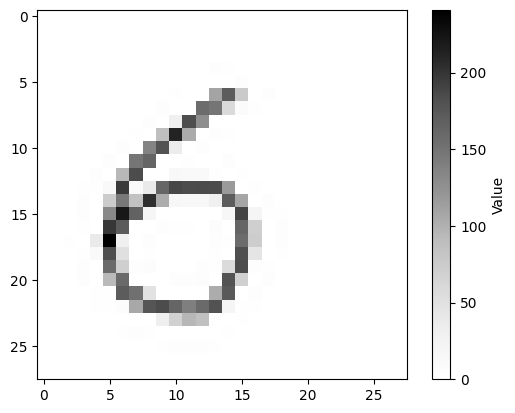

Je crois bien que cela est un [5]


In [58]:
g.TryToDraw()